In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 

In [2]:
spx_path = "data/SPX_database_2010.xlsx"
df_tri = pd.read_excel(spx_path, sheet_name="total_ret").set_index("Dates")

df_sofr = pd.read_excel("./data/sofr.xlsx")
df_sofr.rename(columns={"Data": "Dates"}, inplace=True)
df_sofr["Dates"] = pd.to_datetime(df_sofr["Dates"]) 
df_sofr = df_sofr.set_index("Dates").sort_index()
df_sofr["Taxa_diaria"] = ((1 + df_sofr["Price"]) ** (1/252)) -1
df_sofr

,Price,Taxa_diaria
Dates,,
2014-01-02,0.0005,0.000002
2014-01-03,0.0005,0.000002
2014-01-06,0.0005,0.000002
2014-01-07,0.0004,0.000002
2014-01-08,0.0004,0.000002
...,...,...
2025-07-28,0.0436,0.000169
2025-07-29,0.0436,0.000169
2025-07-30,0.0432,0.000168


In [3]:
# df_tri = df_tri[(df_tri.index.year >= 2000)]
df_sofr = df_sofr[(df_sofr.index.year >= 2000) ]
prices = df_tri.copy()
returns = prices.pct_change()

C:\Users\caio.liberal\AppData\Local\Temp\ipykernel_2328\850101438.py:4: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = prices.pct_change()


In [4]:
def _choose_30(tri_df, random_state=42):
    eligible = sorted(list(map(str, tri_df.columns)))
    rng = np.random.default_rng(random_state)
    chosen = rng.choice(eligible, size=min(30, len(eligible)), replace=False)
    return list(map(str, chosen))

tickers_30 = _choose_30(prices)
tickers_30[:5]

['MSI UN Equity.1',
 'K UN Equity.1',
 'GRMN UN Equity',
 'SW UN Equity.1',
 'AVGO UW Equity.1']

In [7]:
prices = prices[tickers_30]
returns = returns[tickers_30]
prices = df_tri.copy()
prices.index = pd.to_datetime(prices.index)
prices = prices.select_dtypes(include=[np.number]).dropna(how="all", axis=1)

In [11]:
df_precos = prices[tickers_30]

C:\Users\caio.liberal\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
C:\Users\caio.liberal\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
C:\Users\caio.liberal\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
C:\Users\caio.liberal\AppData\Local\Packages\PythonSoftwareFoundation.Python

              ticker  model     const     ar.L1   const_p   ar.L1_p  \
56     AVB UN Equity  AR(1) -0.000208 -0.010889  0.807718  0.791248   
57     AVB UN Equity  MA(1) -0.000207       NaN  0.809484       NaN   
8   AVGO UW Equity.1  AR(1)  0.001836 -0.055905  0.384176  0.151038   
9   AVGO UW Equity.1  MA(1)  0.001840       NaN  0.385983       NaN   
11    AXON UW Equity  MA(1)  0.003169       NaN  0.167736       NaN   
10    AXON UW Equity  AR(1)  0.003175  0.060433  0.168759  0.180020   
20   BLK UN Equity.1  AR(1)  0.001216 -0.015663  0.213736  0.623791   
21   BLK UN Equity.1  MA(1)  0.001215       NaN  0.212008       NaN   
13      CL UN Equity  MA(1) -0.000480       NaN  0.541733       NaN   
12      CL UN Equity  AR(1) -0.000480 -0.009549  0.541589  0.854556   

            AIC          BIC  LB_p(10)  forecast_1     ma.L1   ma.L1_p  
56 -1591.205922 -1580.312286  0.651963   -0.000186       NaN       NaN  
57 -1591.202924 -1580.309289  0.651400   -0.000192 -0.006371  0.876790  

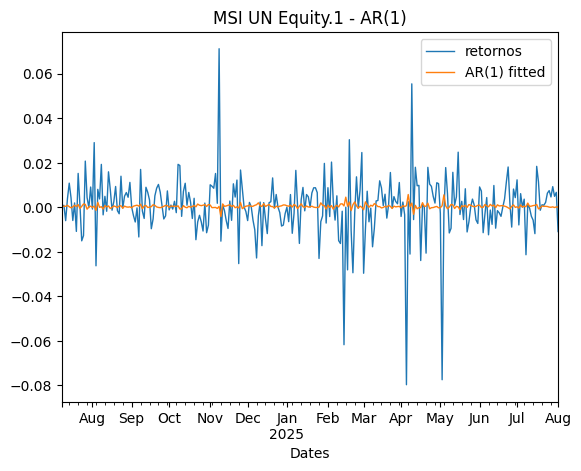

In [ ]:
import numpy as np
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.diagnostic import acorr_ljungbox

# ====== 0) preços -> retornos (log) ======
# df_precos: DataFrame com 30 colunas (tickers), índice por datas (opcional)
df_returns = np.log(df_precos / df_precos.shift(1)).dropna()

# ====== 1) helpers ======
def fit_ar1(series):
    """Ajusta AR(1) e retorna dict com métricas e objetos."""
    res = {"model": "AR(1)"}
    try:
        m = ARIMA(series, order=(1,0,0)).fit()
        lb = acorr_ljungbox(m.resid, lags=[10], return_df=True)  # teste de ruído branco
        res.update({
            "const": m.params.get("const", np.nan),
            "ar.L1": m.params.get("ar.L1", np.nan),
            "const_p": m.pvalues.get("const", np.nan),
            "ar.L1_p": m.pvalues.get("ar.L1", np.nan),
            "AIC": m.aic, "BIC": m.bic,
            "LB_p(10)": float(lb["lb_pvalue"].iloc[0]),
            "fitted_model": m,
            "forecast_1": float(m.forecast(1).iloc[0]),
        })
    except Exception as e:
        res.update({"error": str(e), "fitted_model": None, "forecast_1": np.nan})
    return res

def fit_ma1(series):
    """Ajusta MA(1) e retorna dict com métricas e objetos."""
    res = {"model": "MA(1)"}
    try:
        m = ARIMA(series, order=(0,0,1)).fit()
        lb = acorr_ljungbox(m.resid, lags=[10], return_df=True)
        res.update({
            "const": m.params.get("const", np.nan),
            "ma.L1": m.params.get("ma.L1", np.nan),
            "const_p": m.pvalues.get("const", np.nan),
            "ma.L1_p": m.pvalues.get("ma.L1", np.nan),
            "AIC": m.aic, "BIC": m.bic,
            "LB_p(10)": float(lb["lb_pvalue"].iloc[0]),
            "fitted_model": m,
            "forecast_1": float(m.forecast(1).iloc[0]),
        })
    except Exception as e:
        res.update({"error": str(e), "fitted_model": None, "forecast_1": np.nan})
    return res

results_rows = []      
models_by_ticker = {}    

for ticker in df_returns.columns:
    serie = df_returns[ticker].dropna()
    # AR(1)
    ar_out = fit_ar1(serie)
    ar_row = {"ticker": ticker, **{k:v for k,v in ar_out.items() if k not in ["fitted_model"]}}
    results_rows.append(ar_row)
    # MA(1)
    ma_out = fit_ma1(serie)
    ma_row = {"ticker": ticker, **{k:v for k,v in ma_out.items() if k not in ["fitted_model"]}}
    results_rows.append(ma_row)
    # guardar objetos
    models_by_ticker.setdefault(ticker, {})["AR(1)"] = ar_out.get("fitted_model")
    models_by_ticker.setdefault(ticker, {})["MA(1)"] = ma_out.get("fitted_model")

results = pd.DataFrame(results_rows)

# ====== 3) exemplos de uso ======
# a) ver top 10 pela AIC (melhor = menor)
print(results.sort_values(["ticker", "AIC"]).head(10))

# b) escolher automaticamente entre AR(1) e MA(1) por ticker (menor AIC)
best_by_ticker = (
    results.loc[results.groupby("ticker")["AIC"].idxmin(), :]
    .reset_index(drop=True)
)
print("\nMelhor modelo por ticker (menor AIC):")
print(best_by_ticker[["ticker","model","AIC","BIC","LB_p(10)"]])

t = df_returns.columns[0]
best_model_name = best_by_ticker.set_index("ticker").loc[t, "model"]
print(f"\nTicker {t} | melhor: {best_model_name}")
print("Forecast 1 passo:",
      results[(results["ticker"]==t)&(results["model"]==best_model_name)]["forecast_1"].values[0])

import matplotlib.pyplot as plt
mobj = models_by_ticker[t][best_model_name]
fitted = mobj.fittedvalues
serie = df_returns[t]
serie.tail(500).plot(label="retornos", lw=1)
fitted.reindex_like(serie).tail(500).plot(label=f"{best_model_name} fitted", lw=1)
plt.legend(); plt.title(f"{t} - {best_model_name}"); plt.show()
